# Bioimage Model Zoo Core  Example notebook

This notebook shows how to interact with the `bioimageio.core` programmatically to explore, load, use, and export content from the [BioImage Model Zoo](https://bioimage.io).


quick links:
- [Create an input sample for a given model](#create_sample_for_model)

## Setup

### Running local

If you are running the notebook locally you need to pip install the following dependencies into your local environment. Make sure to restart your notebook kernel after installing dependencies.

```console
pip install bioimageio.core==0.9.1 torch==2.5.1 matplotlib==3.10.1
```

### Running in colab

If you are running this notebook through colab, there is no need to install dependencies manually, just run the following cell.

In [1]:
import os

# install dependencies if running in colab
if os.getenv("COLAB_RELEASE_TAG"):
    %pip install bioimageio.core==0.9. torch==2.5.1 matplotlib==3.10.1

### Install necessary dependencies

In [2]:
from typing import Mapping, Union, Any
from bioimageio.core import Tensor
from numpy.typing import NDArray
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np


from bioimageio.spec.model.v0_5 import TensorId, ModelDescr
from bioimageio.spec.pretty_validation_errors import (
    enable_pretty_validation_errors_in_ipynb,
)

# Improve readiblity of validation errors
enable_pretty_validation_errors_in_ipynb()


# Function to display input and prediction output images
def show_images(
    images: Union[
        Mapping[str, NDArray[Any]], Mapping[TensorId, Union[Tensor, NDArray[Any]]]
    ],
) -> None:
    for title, image in images.items():
        if isinstance(image, Tensor):
            input_array = image.data.data
        else:
            input_array = image

        # Check for the number of channels to enable display
        input_array = np.squeeze(input_array)
        if len(input_array.shape) > 2:
            input_array = input_array[0]
        _ = plt.imshow(input_array)
        _ = plt.title(title)
        _ = plt.axis("off")
        plt.show()

C:\Users\fbeut\AppData\Local\Temp\ipykernel_31848\3069147960.py:16: DeprecationWarning: deprecated, this is enabled by default at import time.
  enable_pretty_validation_errors_in_ipynb()


## Load a model

### Inspect available models in the Bioimage Model Zoo

Go to https://bioimage.io to browser available models

### Load model from the BioImage Model Zoo

`bioimage.io` resources may be identified via their bioimage.io __ID__, e.g. "affable-shark" or the [__DOI__](https://doi.org/) of their [__Zenodo__](https://zenodo.org/) backup.

Both of these options may be version specific ("affable-shark/1" or a version specific [__Zenodo__](https://zenodo.org/) backup [__DOI__](https://doi.org/)).

Alternatively, any rdf.yaml source, single file or in a .zip, may be loaded by providing its __local path__ or __URL__.

**Note** -- For more detailed information about loading a model, inspecting a model's metadata and creating your own model visit [bioimageio.spec package example notebook](https://github.com/bioimage-io/spec-bioimage-io/blob/main/example/load_model_and_create_your_own.ipynb).

In [3]:
model_source = "affable-shark/1.2"
# model_source = "10.5281/zenodo.6287342"
# model_source = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/draft/files/rdf.yaml"

`load_model_description` is a function of the `bioimageio.spec` package, but as it is a sub-package of `bioimageio.core` it can also be called from it by `bioimageio.core.load_model_description`.

To learn more about the functionalities of the `bioimageio.spec` package, see the [bioimageio.spec package example notebook](https://github.com/bioimage-io/spec-bioimage-io/blob/main/example/load_model_and_create_your_own.ipynb), also available as a [Google Colab](https://colab.research.google.com/github/bioimage-io/spec-bioimage-io/blob/main/example/load_model_and_create_your_own.ipynb) notebook.

In [4]:
from bioimageio.core import load_model_description
from bioimageio.core import test_model

model = load_model_description(model_source, format_version="latest")
test_summary = test_model(model)  # Test model to check environment compatibility
assert test_summary.status == "passed", test_summary.display()

## Running a prediction

`bioimageio.core` implements the functionality to run a prediction with models described in the `bioimage.io` format.

This includes functions to run predictions on `numpy.ndarray`/`xarray.DataArray` as input and convenience functions to run predictions for images stored on disc.

### `predict` function 

The most direct way to run a model prediction is using the `bioimageio.core.predict` function, to which you pass the model you want to predict with and the input you want to predict on, along with optional keyword arguments. The input can be given as a `numpy.ndarray`, `xarray.DataArray`, bioimageio `Tensor` or `pathlib.Path` to an image (`TensorSource`).

`bioimageio.core.Tensors/xarray.DataArrays` are like numpy arrays, but they have annotated axes. The axes are used to match the input image to what the model expects. You can create a Tensor instance explicitly if you want to assign a specific axis order.

In [5]:
from bioimageio.spec.utils import load_array

assert isinstance(model, ModelDescr)
input_image = load_array(model.inputs[0].test_tensor)
print(f"array shape: {input_image.shape}")

array shape: (1, 1, 256, 256)


**Note** the `predict` function returns a `Sample` instance which we will discuss in more detail below, but briefly it contains the output tensor along with an id.

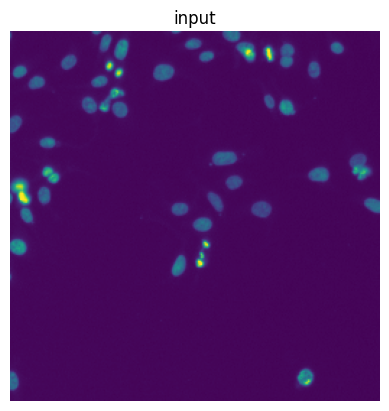

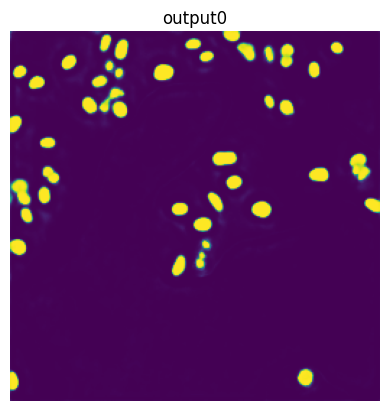

In [6]:
from bioimageio.core import predict
from bioimageio.core import Sample

prediction: Sample = predict(model=model, inputs=input_image)

# show the prediction result
show_images({"input": input_image})
show_images(prediction.members)

Sometimes a model requires multiple inputs to be passed in at once (e.g a raw data input and a mask input). To easily facilitate this inputs can be passed in as a mapping between `MemberId/TensorId` (This is a model specific id that can be found a models description as shown below) and `TensorSource`.

In [7]:
print(
    f"Model '{model.name}' requires {len(model.inputs)} input(s) with the following features:"
)
for ipt in model.inputs:
    print(f"\ninput '{ipt.id}' with axes:")
    pprint([(a.id, a.size) for a in ipt.axes])
    print(f"Data description: {ipt.data}")
    print(f"Test tensor available at:  {ipt.test_tensor.source.absolute()}")

Model 'NucleiSegmentationBoundaryModel' requires 1 input(s) with the following features:

input 'input0' with axes:
[('batch', None),
 ('channel', 1),
 ('y', ParameterizedSize(min=64, step=16)),
 ('x', ParameterizedSize(min=64, step=16))]
Data description: type='float32' range=(None, None) unit='arbitrary unit' scale=1.0 offset=None
Test tensor available at:  https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.2/files/test_input_0.npy


**Note** Batch size of None is a convention and just means that there is no restriction on batch size and it can be any positive integer.

**Note** In the above print out we can also see the axis order that the model expects, in some cases it may be importatn to explicity set this order and ensure that your input data matches. As mentioned before can set he axes order by using a `bioimageio.core.Tensors/xarray.DataArrays` instance.

In [8]:
input_tensor = Tensor.from_numpy(input_image, dims=model.inputs[0].axes)

# print the axis annotations ('dims') and the shape of the input array
print(f"tensor shape: {input_tensor.tagged_shape}")

tensor shape: Frozen({'batch': 1, 'channel': 1, 'y': 256, 'x': 256})


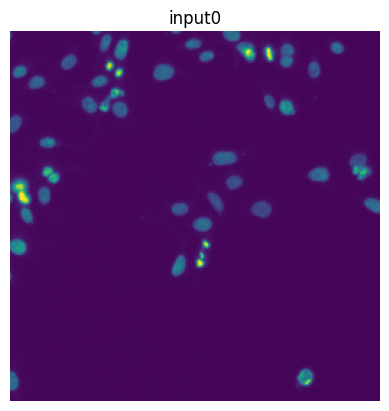

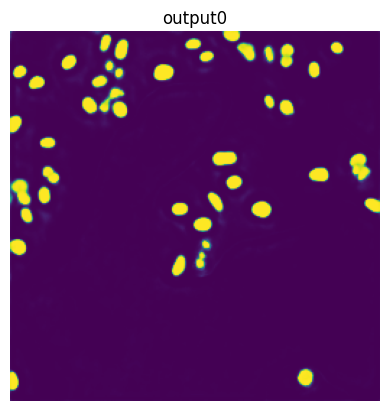

In [9]:
input = {model.inputs[0].id: input_tensor}

prediction: Sample = predict(model=model, inputs=input)

# show the input and prediction result
show_images(input | prediction.members)

Alternatively, instead of directly setting input as a Mapping[TensorId, TensorSource] we can set input to be a `Sample` instance. Inside `predict` a `Sample` will actually be created no matter the given input type. The `Sample` instance can be created explicitly for a given model using the helper function `create_sample_for_model`. Another useful functionality of `Sample` is that it can keep track of precomputed sample and dataset statistics, which certain preprocessing steps require.

In order to create a `Sample` we first create a `Tensor` (light wrapper around an `xarray.DataArray`) from the test input image, adding annotated axes.

In [10]:
test_input_tensor = Tensor.from_numpy(input_image, dims=model.inputs[0].axes)

# print the axis annotations ('dims') and the shape of the input array
print(f"tensor shape: {test_input_tensor.tagged_shape}")

tensor shape: Frozen({'batch': 1, 'channel': 1, 'y': 256, 'x': 256})


A collection of tensors is called a `Sample`.

In the case of the `affable-shark` model it only has one input, but for models with multiple inputs a `Sample` includes a tensor for each input.

In [11]:
from bioimageio.core import Sample
from bioimageio.core.stat_measures import DatasetMean

sample = Sample(
    members={"raw": test_input_tensor},
    stat={DatasetMean(member_id=TensorId("raw")): 123.456},  # Example mean value
    id="sample-from-numpy",
)

sample

Sample(members={'raw': <bioimageio.core.tensor.Tensor object at 0x0000017E1DEDDDE0>}, stat={DatasetMean(member_id='raw', scope='dataset', name='mean', axes=None): 123.456}, id='sample-from-numpy')

`bioimageio.core` provides the helper function `create_sample_for_model` to automatically create the `Sample` for the given model.
<a id='create_sample_for_model'></a>

In [12]:
from bioimageio.core.digest_spec import create_sample_for_model
from bioimageio.spec.utils import download

input_paths = {ipt.id: ipt.test_tensor.source for ipt in model.inputs}
print(f"input paths: {input_paths}")
assert isinstance(model, ModelDescr)
sample = create_sample_for_model(
    model=model, inputs=input_paths, sample_id="my_demo_sample"
)

sample

input paths: {'input0': RelativePath('test_input_0.npy')}


Sample(members={'input0': <bioimageio.core.tensor.Tensor object at 0x0000017E02194BB0>}, stat={}, id='my_demo_sample')

There is also  a helper function `get_test_inputs` to directly import the test input sample for a given model.

In [13]:
from bioimageio.core.digest_spec import get_test_inputs

test_sample = get_test_inputs(model)

test_sample

Sample(members={'input0': <bioimageio.core.tensor.Tensor object at 0x0000017E23EFBC70>}, stat={}, id='test-sample')

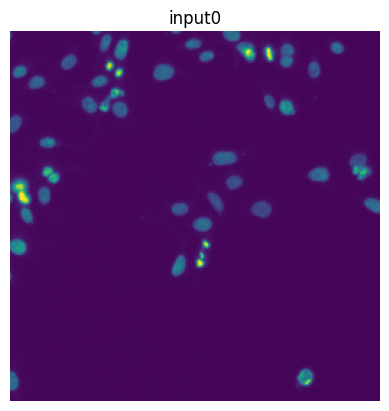

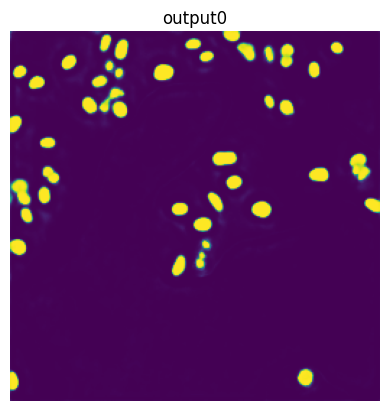

In [14]:
prediction: Sample = predict(model=model, inputs=sample)

# show the prediction result
show_images(sample.members)
show_images(prediction.members)

### `Predict_many` function

If you need to do many predictions it more effcient to use the `predict_many` function. This avoids reloading the model (onto GPU) repeatably for each sample, which happens for the `predict` function.

  0%|          | 0/1 [00:00<?, ?it/s]

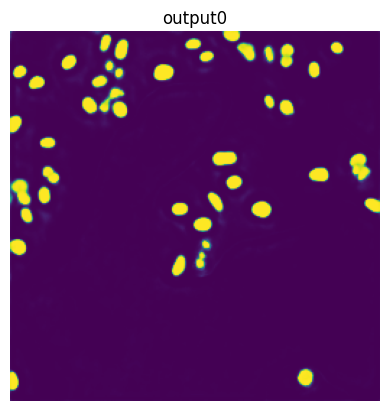

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


In [15]:
from bioimageio.core import predict_many

for prediction in predict_many(model=model, inputs=[sample]):
    show_images(prediction.members)

### Prediciton pipeline (Advanced)

The `prediction_pipeline` function is used to run a prediction with a given model and provides more finegrained control for model prediction.

It applies the __pre-processing__, if indicated in the model rdf.yaml, runs __inference__ with the model and applies the __post-processing__, again if specified in the model rdf.yaml.

The `devices` argument can be used to specify which device(s), CPU, a single GPU, or multiple GPUs (not implemented yet), to use for inference with the model.

The default is `devices=None`, this will use a __GPU__ if available, otherwise it uses the __CPU__.


The `weight_format` argument can be used to specify which of the model's available weight formats to use.

The deafult is `weight_format=None`, this will use the weight format with highest priority (as defined by bioimageio.core).



In [16]:
from bioimageio.core import create_prediction_pipeline

devices = None
weight_format = None

prediction_pipeline = create_prediction_pipeline(
    model, devices=devices, weight_format=weight_format
)

Use the new prediction pipeline to run a prediction for the previously loaded test image.

The prediction pipeline also returns a `Sample` object, which will be displayed.

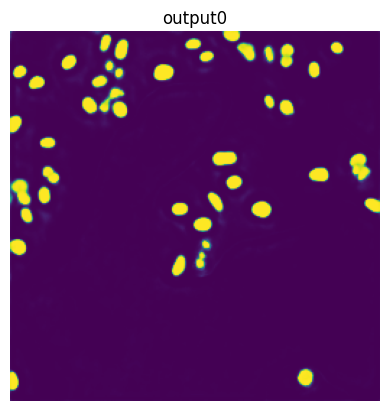

In [17]:
prediction: Sample = prediction_pipeline.predict_sample_without_blocking(sample)

# show the prediction result
show_images(prediction.members)

### Recover input and output tensors as numpy arrays

This example code shows how to recover the image information from the input and output tensors as numpy arrays.

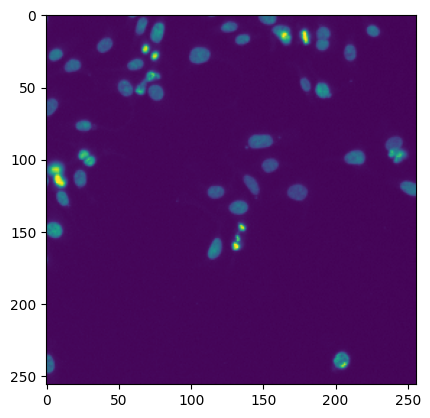

In [18]:
np_input_list = []
np_output_list = []

# iterate over the number of tensors inside the input sample
for ipt in range(len(sample.members.keys())):
    input_array = sample.members[f"input{ipt}"].data

    # Check for the number of channels to enable display
    input_array = np.squeeze(input_array)
    if len(input_array.shape) > 2:
        input_array = input_array[0]

    np_input_list.append(input_array)


# iterate over the number of tensors inside the output prediction
for out in range(len(prediction.members.keys())):
    output_array = prediction.members[f"output{ipt}"].data

    # Check for the number of channels to enable display
    output_array = np.squeeze(output_array)
    if len(output_array.shape) > 2:
        output_array = output_array[0]

    np_output_list.append(output_array)

_ = plt.imshow(np_input_list[0])
plt.show()